In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import tqdm
import re
import math
import statistics
import sys
import string
import ast
import logging
import matplotlib.pyplot as plt
from fuzzywuzzy import fuzz
from tqdm.auto import tqdm
from typing import List, Tuple
from data.make_data import get_links, is_article, save_links, extract_links, get_date_from_url, extract_links_main

sys.path.append('../hot_links')
# TODO Something like this in dataset.py
# from hot_links.config import PROCESSED_DATA_DIR, RAW_DATA_DIR

from hot_links.vector_db_utils import *
from hot_links.eval_utils import *

from openai import OpenAI

client = OpenAI()

np.random.seed(41)

logging.basicConfig(filename='out.log', filemode='a', level=logging.DEBUG)
logger = logging.getLogger(__name__)

/workspaces/hot-links/.venv/lib/python3.12/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
/workspaces/hot-links/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-09-15 21:10:21.678 | INFO     | hot_links.config:<module>:11 - PROJ_ROOT path is: /workspaces/hot-links


In [3]:
vs_name = 'hot_links'

vector_store_id = get_vector_store_id(vs_name = vs_name)

if not vector_store_id:
    print('Creating...')
    logger.info('Creating vs {vs_name}')
    vector_store_id = create_vs(vs_name)
    
logger.info('Set up {vs_name}')

In [4]:
df_seed = pd.read_csv('../data/processed/seed.csv')
## Assumes you haven't done snowballing

df_seed['links'] = df_seed['links'].apply(ast.literal_eval)

In [12]:
df_snowball = pd.read_csv('../data/processed/snowball_1.csv')
df_snowball['links'] = df_snowball['links'].apply(ast.literal_eval)

## Mean snippet length could be useful

In [75]:
df_seed['links'].apply(lambda x:[len(l['link'].split(' ')) for l in x]).explode().mean()

np.float64(5.116363182838613)

## Starting with an article and a document link, find the snippet to insert it

In [6]:
test_article = df_seed.iloc[5,:]

In [7]:
test_article_links = [d['href']+'.txt' for d in test_article['links']]
test_article_snippets = [d['link'] for d in test_article['links']]

In [8]:
n_test_snippet = 1

In [9]:
test_article_links[n_test_snippet]

'https://www.theguardian.com/sport/2015/dec/01/sebastian-coe-damien-collins-humility-iaaf.txt'

In [10]:
test_article_snippets[n_test_snippet]

'Sebastian Coe regarding doping'

In [13]:
df_snowball.head()['url'].values

array(['https://www.theguardian.com/australia-news/2015/aug/17/push-to-bring-back-abcc-building-industry-watchdog-blocked-by-senate',
       'https://www.theguardian.com/technology/2016/feb/19/fbi-apple-san-bernardino-shooter-court-order-iphone',
       'https://www.theguardian.com/commentisfree/2016/feb/05/the-zika-outbreak-share-your-stories-views-and-experiences',
       'https://www.theguardian.com/sport/2015/dec/01/sebastian-coe-damien-collins-humility-iaaf',
       'https://www.theguardian.com/sport/2016/jan/18/tennis-match-fixing-claims-authorities-absolutely-reject-any-cover-up'],
      dtype=object)

In [14]:
link_content = (df_snowball[df_snowball['url']+'.txt' == test_article_links[1]]).iloc[0,:].content

In [15]:
query = 'I want to link to document 2 from document 1. Give me the most appropriate substring from document 1 to link to document 2. Return the anchor text only\n \
--- \n Document 1 \n -----\n {:s}'  '\n \
--- \n Document 2 \n -----\n {:s}'.format(test_article['bodyContent'], link_content)

In [16]:
print(query)

I want to link to document 2 from document 1. Give me the most appropriate substring from document 1 to link to document 2. Return the anchor text only
 --- 
 Document 1 
 -----
 Giles Clarke, the England and Wales Cricket Board president, will be summoned to answer questions by the Commons culture, media and sport select committee over his role in the controversial “Big Three” takeover of the International Cricket Council. Clarke, the former ECB chairman, was central to the reforms in early 2014 that led to India, England and Australia taking greater control of cricket’s governing body and allocating themselves 52% of revenues generated by international events. With the select committee having spoken to Greg Dyke, the FA chairman, over Fifa corruption, the athletics chief Sebastian Coe regarding doping and Chris Kermode of the ATP on the subject of match-fixing in tennis, it will now turn its attention to cricket’s governance.
“The committee has decided to look into the conduct of the

In [18]:
response = client.responses.create(
  model="gpt-4.1",
  input=query
)

In [19]:
test_article = df_seed.iloc[9,:]

## Look carefully at sub-string matches first

In [17]:
def get_substring_match_location(doc,ss, v = False):
    
    translator = str.maketrans('', '', string.punctuation)
    doc = doc.translate(translator).lower()
    ss = ss.translate(translator).lower()
    # Strip out punctuation from both, less confusion in identifying overlaps
    
    matches = []
    
    for n,w in enumerate(doc.split()[0:-len(ss.split())+1]):
        if v: print('Starting at',n, 'word', w)

        ss_match = True
        
        for nn in range(0,len(ss.split())):
            if v: print('\t Checking', nn, 'word', doc.split()[nn+n], ss.split()[nn])
            if not doc.split()[nn+n] == ss.split()[nn]:
                ss_match = False
        if ss_match:
            if v:print('Match at position', n, 'to', n + len(ss.split()), 'for', ss, 'in', doc)
            matches.append((n, n + len(ss.split())))
    return matches
    

In [18]:
get_substring_match_location('Ummm. This is a test. OK? This is a test.', 'This is a')

[(1, 4), (6, 9)]

In [40]:
def get_overlap_stats(o1:List[Tuple[int,int]],o2:List[Tuple[int,int]]) -> Tuple[bool, bool, int, int, float, float]:
    
    is_perfect_match = False
    is_partial_overlap = False
    overlap_ratio_1 = 99999
    overlap_ratio_2 = 99999
    
    n_overlap_1 = 0
    n_overlap_2 = 0
    ratio_1 = 0.0
    ratio_2 = 0.0
    # Need to initialise these here in case there are zero snippets for some reason
            
    for oo1 in o1:
        for oo2 in o2:
        # Brute force comparison in case of multiple matches
        # Be optimistic and take the best overlap in case of multiple
        # TODO get LLM to output exact word locations to disambiguate
            if oo1 == oo2:
                is_perfect_match = True
    
            if oo1[0] >= oo2[0] and oo1[0] < oo2[1]:
                is_partial_overlap = True
            if oo1[1] <= oo2[1] and oo1[1] > oo2[0]:
                is_partial_overlap = True
                
            # Calculate overlap ratio
            
            n_overlap_1 = 0
            n_overlap_2 = 0
            
            # Scan original snippet first
            for i in range(oo1[0],oo1[1]):
                if i < oo2[1] and i>= oo2[0]:
                    n_overlap_1 +=1
            ratio_1 = n_overlap_1/ (oo1[1] - oo1[0])
            
            if ratio_1 < overlap_ratio_1:
                overlap_ratio_1 = ratio_1
                
            # Next scan suggested snippt
            for i in range(oo2[0],oo2[1]):
                if i <oo1[1] and i>= oo1[0]:
                    n_overlap_2 +=1
            ratio_2 = n_overlap_2/ (oo2[1] - oo2[0] )
            
            if ratio_2 < overlap_ratio_2:
                overlap_ratio_2 = ratio_2
            
            # TODO get absolute distance between snippets in article
    
    if n_overlap_1 == 0 and len(o1) > 0 and len(o2) > 0:
        # There is an edge case here where oo2 is not defined
        separation = min(abs(oo2[0] - oo1[1]),abs(oo2[1] - oo1[0]))
    else:
        separation = 0
            
                
    return is_perfect_match, is_partial_overlap,n_overlap_1, n_overlap_2, ratio_1, ratio_2, separation

In [48]:
def get_snippets_from_links(test_article,model = "gpt-4.1", v = False):
    test_article_links = [d['href']+'.txt' for d in test_article['links']]
    test_article_snippets = [d['link'] for d in test_article['links']]

    if v:print('Original focal article:', test_article['webUrl'])
    
    n_error = 0
    # Check how many proposed snippets are actually substrings of the article body
    # Low powered models sometimes confuse snippets from focal article and linked article
    
    all_overlap_stats = []
    # Store all stats of how real and generated snippets overlap for all links

    for link,snippet in zip(test_article_links, test_article_snippets):
        if v:print('Link: {:s}\n>>>>>>> {:s}'.format(link,snippet))
        
        link_content = None
        
        results = (df_snowball[df_snowball['url']+'.txt' == link])
        if results.shape[0] == 0:
            if v:print('No results found in snowball....')
            # TODO find out why some links are missing
            # Hiding in df_seed? Seems yes
            
        else:
            link_content = results.iloc[0,:].content
            
        if not link_content:
            results = df_seed[df_seed['webUrl'] == link.split('.txt')[0]]
            
            if results.shape[0] == 0:
                print('...No results found in seed...')
            else:
                if v:print('....Found in seed')
                link_content = results.iloc[0,:].bodyContent

        if link_content:
            query = 'I want to link to document 2 from document 1. Give me the most appropriate substring from document 1 to place the link to document 2. The text must be a substring of document 1 and not document 2. Return the anchor text only. The substring is typically 5 words long on average\n \
            --- \n Document 1 \n -----\n {:s}'  '\n \
            --- \n Document 2 \n -----\n {:s}'.format(test_article['bodyContent'], link_content)

            
            response = client.responses.create(
            model="gpt-4.1",
            input=query, prompt_cache_key=test_article['webUrl'][0:64])
            # Use URL as a unique key to cache similar articles, limited to 64 chars
            
            if v:print('<<<<<<', response.output[0].content[0].text)
            
            
            ##### Substring evaluation
            if response.output[0].content[0].text in snippet or snippet in response.output[0].content[0].text:
                if v:print('++++ Overlap with original snippet')

            overlap_1 = get_substring_match_location(test_article['bodyContent'], snippet)
            overlap_2 = get_substring_match_location(test_article['bodyContent'], response.output[0].content[0].text)
            
            if v:
                print('Overlaps:',overlap_1)
                print('Overlaps:',overlap_2)

            all_overlap_stats.append(get_overlap_stats(overlap_1, overlap_2) + (snippet,response.output[0].content[0].text))
            
            # TODO test to see if snippet is a substring of response
            # This needs to be done carefully to capture overlap at the same point in the article
            
            if not response.output[0].content[0].text in test_article['bodyContent']:
                if v:print('!!!! Warning: snippet not found in article body')
                n_error+=1
            if response.output[0].content[0].text in link_content:
                if v:print('!!!! Warning: snippet found in linked article body')
        if v:print('\n')
    return n_error, pd.DataFrame(data = all_overlap_stats, columns = ['is_perfect_match', 'is_partial_overlap','n_overlap_1', 'n_overlap_2', 'ratio_1', 'ratio_2', 'separation', 'snippet', 'proposal'])

In [20]:
get_overlap_stats([[2,3]],[[1,3]])

(False, True, 1, 1, 1.0, 0.5, 0)

In [21]:
assert get_overlap_stats([[0,3]],[[0,3]]) == (True, True, 3, 3, 1.0,1.0,0)
assert get_overlap_stats([[2,3]],[[1,3]]) == (False, True, 1, 1, 1.0, 0.5,0)

assert get_overlap_stats([[0,3]],[[9,11]]) == (False, False,0,0,0.0,0.0,6)
assert get_overlap_stats([[0,3]],[[3,6]]) == (False, False, 0,0,0.0,0.0,0)

In [38]:
test_article = df_seed.iloc[5,:]

n_error,results_df = get_snippets_from_links(test_article, v = False)
results_df

ResponseUsage(input_tokens=1485, input_tokens_details=InputTokensDetails(cached_tokens=0), output_tokens=11, output_tokens_details=OutputTokensDetails(reasoning_tokens=0), total_tokens=1496)
ResponseUsage(input_tokens=1063, input_tokens_details=InputTokensDetails(cached_tokens=0), output_tokens=9, output_tokens_details=OutputTokensDetails(reasoning_tokens=0), total_tokens=1072)
ResponseUsage(input_tokens=2356, input_tokens_details=InputTokensDetails(cached_tokens=0), output_tokens=9, output_tokens_details=OutputTokensDetails(reasoning_tokens=0), total_tokens=2365)
ResponseUsage(input_tokens=1728, input_tokens_details=InputTokensDetails(cached_tokens=0), output_tokens=14, output_tokens_details=OutputTokensDetails(reasoning_tokens=0), total_tokens=1742)


,is_perfect_match,is_partial_overlap,n_overlap_1,n_overlap_2,ratio_1,ratio_2,separation,snippet,proposal
0,False,True,4,4,1.0,0.500000,0,spoken to Greg Dyke,"having spoken to Greg Dyke, the FA chairman"
1,False,True,4,4,1.0,0.571429,0,Sebastian Coe regarding doping,the athletics chief Sebastian Coe regarding do...
2,False,True,4,4,0.4,0.666667,0,Chris Kermode of the ATP on the subject of mat...,the subject of match-fixing in tennis
3,False,False,0,0,0.0,0.000000,222,Change Cricket campaign,"""the so-called “Big Three” takeover of the ICC"""


## Evaluate substring matches

In [57]:
n_eval = 10

all_n_error = 0
all_total = 0

all_results_df = pd.DataFrame()

for row in tqdm.tqdm(df_seed.sample(n_eval).iterrows()):
    test_article = row[1]
    #print('Evaluating article:', test_article.webUrl)
    #print('{:d} links to evaluate'.format(len(test_article['links'])))
    n_error, results_df = get_snippets_from_links(test_article, model = "gpt-5", v=False)

    if results_df.shape[0] > 0:
        all_results_df = pd.concat([all_results_df,results_df])
    all_n_error+=n_error
    all_total += results_df.shape[0]
    
print('Number of errors found:', n_error)

0it [00:00, ?it/s]

10it [00:29,  2.93s/it]

Number of errors found: 0


In [45]:
results_dict ={}

In [58]:
results_dict['gpt-5'] = [all_results_df,all_n_error]

## Do quick comparison of model confusion rates

In [73]:
for model,res in results_dict.items():
    print('Testing model:', model)
    print('-----------------------------------')
    #print('Number of errors found:', res[1])
    print('Percentage errors found {:.1f}'.format(100. * res[1]/res[0].shape[0]))
    print('Mean generated snippet overlap ratio = {:.2f}'.format(res[0]['ratio_2'].mean()))
    print()

Testing model: gpt-4.1-mini
-----------------------------------
Percentage errors found 32.0
Mean generated snippet overlap ratio = 0.16

Testing model: gpt-4.1-nano
-----------------------------------
Percentage errors found 31.6
Mean generated snippet overlap ratio = 0.34

Testing model: gpt-4.1
-----------------------------------
Percentage errors found 20.0
Mean generated snippet overlap ratio = 0.41

Testing model: gpt-5-mini
-----------------------------------
Percentage errors found 31.6
Mean generated snippet overlap ratio = 0.10

Testing model: gpt-5
-----------------------------------
Percentage errors found 33.3
Mean generated snippet overlap ratio = 0.14



In [80]:
import collections

In [82]:
results_dict_ordered = collections.OrderedDict(results_dict)

In [98]:
results_dict_ordered.keys()

odict_keys(['gpt-4.1-mini', 'gpt-4.1-nano', 'gpt-4.1', 'gpt-5-mini', 'gpt-5'])

### Look at overlap ratio

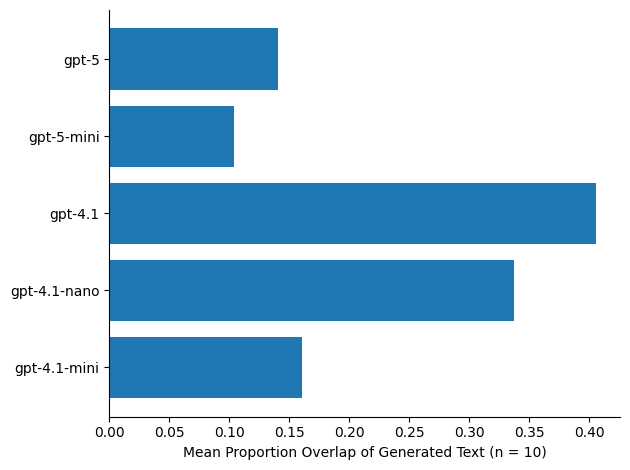

In [106]:
fig, ax = plt.subplots()

ax.barh(range(len(results_dict_ordered)),list(map(lambda x:x[0]['ratio_2'].mean(),results_dict_ordered.values())))
_ = plt.yticks(range(len(results_dict_ordered)),results_dict_ordered.keys())
_ = plt.xlabel('Mean Proportion Overlap of Generated Text (n = {:d})'.format(n_eval))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('../reports/figures/overlap_by_model.png',dpi = 300)

### Look at separation

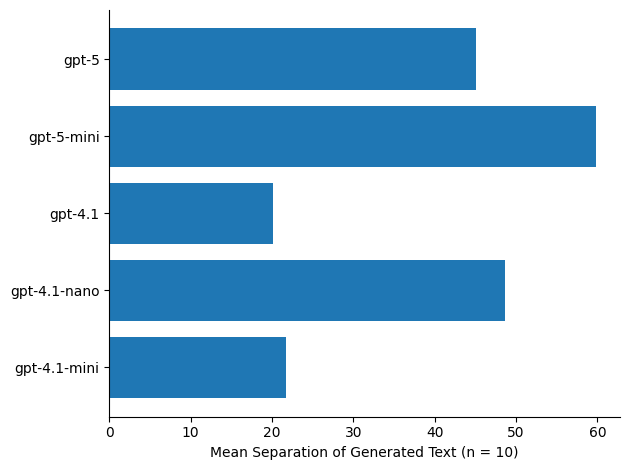

In [112]:
fig, ax = plt.subplots()

ax.barh(range(len(results_dict_ordered)),list(map(lambda x:x[0]['separation'].mean(),results_dict_ordered.values())))
_ = plt.yticks(range(len(results_dict_ordered)),results_dict_ordered.keys())
_ = plt.xlabel('Mean Separation of Generated Text (n = {:d})'.format(n_eval))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('../reports/figures/separation_by_model.png',dpi = 300)

### Count perfect matches

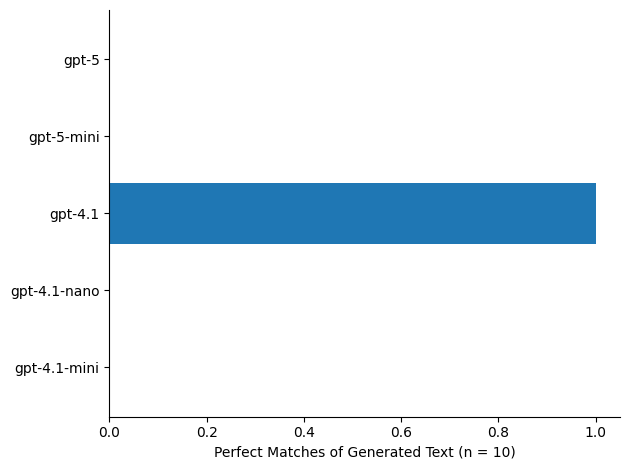

In [111]:
fig, ax = plt.subplots()

ax.barh(range(len(results_dict_ordered)),list(map(lambda x:x[0]['is_perfect_match'].sum(),results_dict_ordered.values())))
_ = plt.yticks(range(len(results_dict_ordered)),results_dict_ordered.keys())
_ = plt.xlabel('Perfect Matches of Generated Text (n = {:d})'.format(n_eval))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('../reports/figures/perfect_matches_by_model.png',dpi = 300)

### Count partial matches

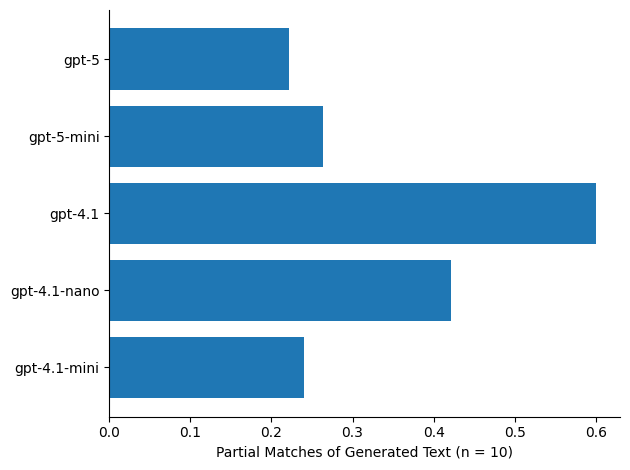

In [119]:
fig, ax = plt.subplots()

ax.barh(range(len(results_dict_ordered)),list(map(lambda x:x[0]['is_partial_overlap'].sum()/x[0].shape[0],results_dict_ordered.values())))
_ = plt.yticks(range(len(results_dict_ordered)),results_dict_ordered.keys())
_ = plt.xlabel('Partial Matches of Generated Text (n = {:d})'.format(n_eval))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('../reports/figures/partial_matches_by_model.png',dpi = 300)

In [116]:
results_dict['gpt-4.1'][0]

,is_perfect_match,is_partial_overlap,n_overlap_1,n_overlap_2,ratio_1,ratio_2,separation,snippet,proposal
0,False,True,6,6,0.600000,1.000000,0,continued to stay in the Australian federal po...,the Australian federal police training college
0,False,True,5,5,0.833333,1.000000,0,flagged banning the use of brokers,banning the use of brokers
0,False,False,0,0,0.000000,0.000000,92,last Saturday’s dismal defeat by Southampton,the latest disappointing display from Van Gaal...
1,False,True,4,4,1.000000,0.800000,0,1-0 win at Liverpool,the 1-0 win at Liverpool
0,False,False,0,0,0.000000,0.000000,29,their No1 January transfer target,the need for cover up front
0,False,True,5,5,1.000000,0.555556,0,dead and dying sperm whales,the tragic scenes of dead and dying sperm whales
1,False,True,2,2,1.000000,0.400000,0,Bowie’s death,the days after Bowie’s death
2,False,True,2,2,1.000000,0.400000,0,cat gifs,cat gifs are to us
0,False,False,0,0,0.000000,0.000000,0,who died in January,For the most appropriate anchor text (5 words ...
1,False,True,3,3,1.000000,0.500000,0,with Wes Craven,**along with Wes Craven and Christopher**
